## Predict whether the Tweet is a real Disaster or Not?
### Target = 1 means Real Disaster Tweet or else Target =0 Not Real Disaster Tweet

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re,string
import category_encoders as ce


import nltk
from nltk import FreqDist,word_tokenize
from wordcloud import STOPWORDS
from nltk import bigrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

## Exploratory Data Analysis

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
print("Length of Train Data",len(train_data))
print("Length of Test Data",len(test_data))

Length of Train Data 7613
Length of Test Data 3263


In [3]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [4]:
# Check for Duplicates
train_data.duplicated().sum()

0

In [5]:
train_data = train_data.drop_duplicates().reset_index(drop=True)
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


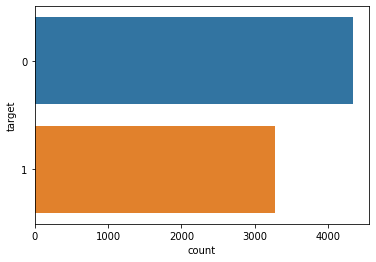

In [6]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train_data.target);

In [7]:
"""
Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.
"""
print("Train Data",train_data.isnull().sum())
print("Test Data",test_data.isnull().sum())

Train Data id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Test Data id             0
keyword       26
location    1105
text           0
dtype: int64


         id  keyword                       location  \
31       48   ablaze                     Birmingham   
32       49   ablaze  Est. September 2012 - Bristol   
33       50   ablaze                         AFRICA   
34       52   ablaze               Philadelphia, PA   
35       53   ablaze                     London, UK   
...     ...      ...                            ...   
7578  10830  wrecked                            NaN   
7579  10831  wrecked              Vancouver, Canada   
7580  10832  wrecked                        London    
7581  10833  wrecked                        Lincoln   
7582  10834  wrecked                            NaN   

                                                   text  target  
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
32    We always try to bring the heavy. #metal #RT h...       0  
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
34                   Crying out for more! Set me ablaze       0  
35    On 

Text(0, 0.5, 'samples')

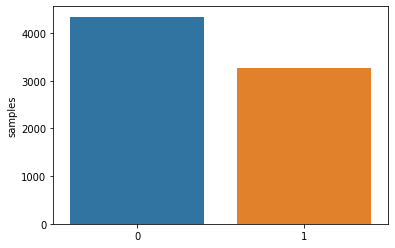

In [8]:
print(train_data[~train_data['keyword'].isnull()])
"""
Class Distribution of the Target Variable. There are more tweets with class 0 ( No disaster) 
than class 1 ( disaster tweets)
"""
x = train_data.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [9]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train_data.keyword.nunique(), test_data.keyword.nunique())
print (set(train_data.keyword.unique()) - set(test_data.keyword.unique()))

221 221
set()


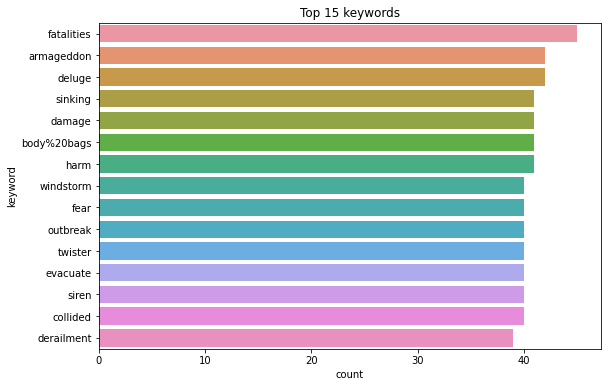

In [10]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_data.keyword, order = train_data.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

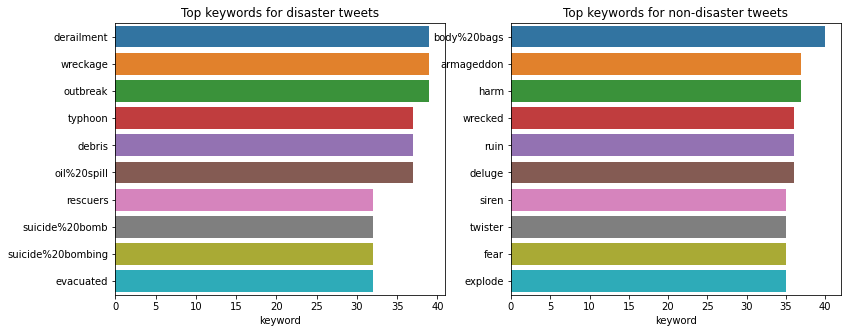

In [11]:
"""
There is no common top 10 keywords between Disaster and Non-Disaster Tweets
"""
diasater_keyword = train_data[train_data['target'] == 1].keyword.value_counts().head(10)
nonDisaster_keyword = train_data[train_data['target'] == 0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(diasater_keyword, diasater_keyword.index)
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(nonDisaster_keyword, nonDisaster_keyword.index)
plt.title('Top keywords for non-disaster tweets')
plt.show()

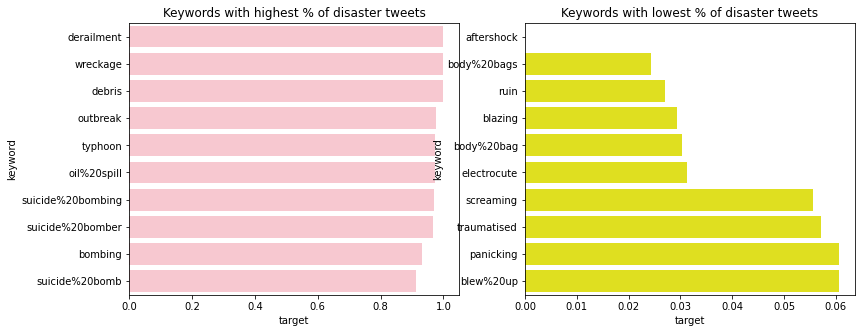

In [12]:
top_d = train_data.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train_data.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## Data Cleaning & Creating Seperate Hashtags , Mentions and Links

In [13]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text


def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train_data = process_text(train_data)
test_data = process_text(test_data)

train_data

,id,keyword,location,text,target,text_clean,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,no,no,http://t.co/STfMbbZFB5
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,no,aria_ahrary TheTawniest,no
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,no,no,http://t.co/zDtoyd8EbJ
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,no,no,no


In [14]:
def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train_data = create_stat(train_data)
test_data = create_stat(test_data)

print(train_data.shape, test_data.shape)


(7613, 18) (3263, 17)


In [15]:
# Correlation
# All the features are having lower correlation with the Target Variable

train_data.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

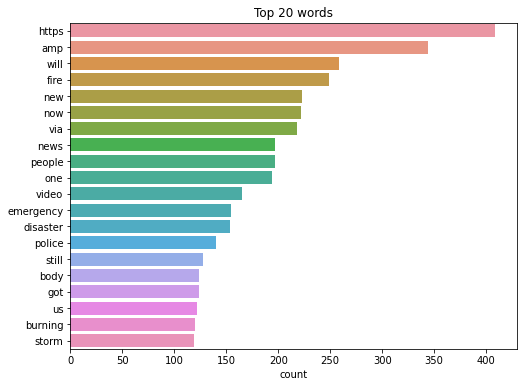

In [16]:
"""
Most Frequent Words amnd Bigrams
"""
stopwords = set(STOPWORDS)
word_freq = FreqDist(w for w in word_tokenize(' '.join(train_data['text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

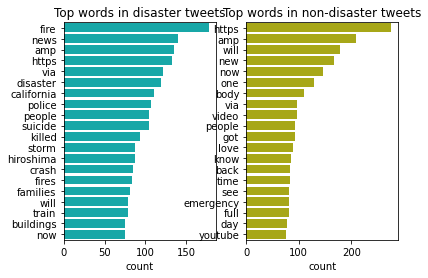

In [17]:

"""
Observation
Top two words in disaster tweets: 'fire' and 'news'.
Words are more specific for real disaster tweets (e.g. 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb').
"""
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train_data.loc[train_data.target==1, 'text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)


freq_nd = FreqDist(w for w in word_tokenize(' '.join(train_data.loc[train_data.target==0, 'text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()


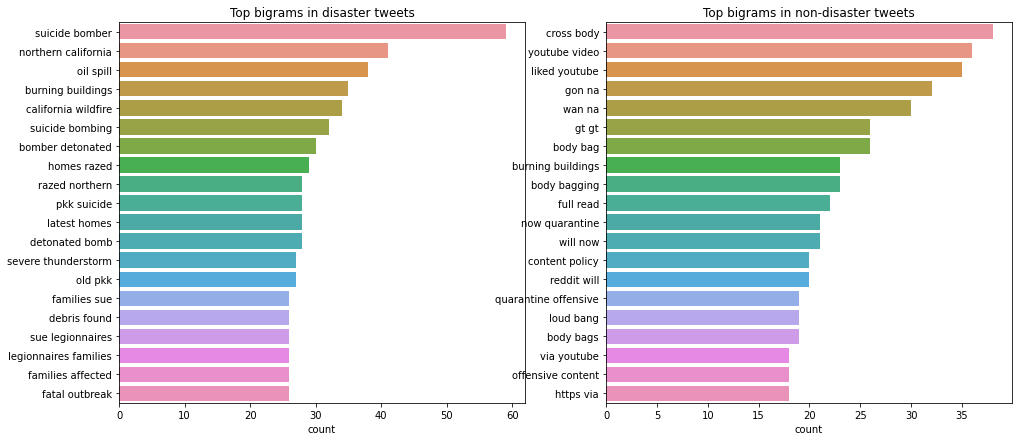

In [18]:
# Bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train_data.loc[train_data.target==1, 'text']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20])
plt.title('Top bigrams in disaster tweets')

plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train_data.loc[train_data.target==0, 'text']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20])
plt.title('Top bigrams in non-disaster tweets')
plt.show()

### Encoding & Vectorizers


In [19]:
features = ['keyword']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train_data[features],train_data['target'])

train_data = train_data.join(encoder.transform(train_data[features]).add_suffix('_target'))
test_data = test_data.join(encoder.transform(test_data[features]).add_suffix('_target'))

In [20]:
train_data.isnull().sum()

id                      0
keyword                61
location             2533
text                    0
target                  0
text_clean              0
hashtags                0
mentions                0
links                   0
text_len                0
word_count              0
stop_word_count         0
punctuation_count       0
hashtag_count           0
mention_count           0
link_count              0
caps_count              0
caps_ratio              0
keyword_target          0
dtype: int64

In [21]:
# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train_data['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())

men_vec_test = vec_men.transform(test_data['mentions'])
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

X_train_men

,ap,arianagrande,change,djicemoon,emmerdale,foxnews,invalid,justinbieber,mikeparractor,no,potus,stretcher,towel,usagov,usatoday,viralspell,youngheroesid,youtube
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [22]:
# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train_data['links'])
link_vec_test = vec_links.transform(test_data['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

X_train_link

,http://t.co/cybksxhf7d,http://t.co/encmhz6y34,http://t.co/ksawlyux02,http://t.co/q2eblokeve,http://t.co/qew4c5m1xd,http://t.co/vvplfqv58p
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
7608,0,0,0,0,0,0
7609,0,0,0,0,0,0
7610,0,0,0,0,0,0
7611,0,0,0,0,0,0


In [23]:
# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train_data['hashtags'])
hash_vec_test = vec_hash.transform(test_data['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)
X_train_hash


(7613, 6) (7613, 18) (7613, 107)


,abstorm,africa,afterlife,allah,animalrescue,antioch,armageddon,art,bb17,bbc,...,usa,usgs,wildfire,wildfires,wmata,womens,world,worldnews,wx,yyc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
"""
TF-IDF Vectoriser
"""

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train_data['text_clean'])
text_vec_test = vec_text.transform(test_data['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)
X_train_text

(7613, 1691)


,00,01,04,05,06,07,08,08 05,08 06,10,...,û_,ûª,ûªs,ûªt,ûªve,ûï,ûïwhen,ûïwhen saw,ûò,ûó
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.340738,0.361616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
X_train_hash

,abstorm,africa,afterlife,allah,animalrescue,antioch,armageddon,art,bb17,bbc,...,usa,usgs,wildfire,wildfires,wmata,womens,world,worldnews,wx,yyc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
train_data = train_data.join(X_train_link)
train_data = train_data.join(X_train_men)
train_data = train_data.join(X_train_hash,rsuffix='_hashtag')
train_data = train_data.join(X_train_text,rsuffix='_text')

test_data = test_data.join(X_test_link)
test_data = test_data.join(X_test_men)
test_data = test_data.join(X_test_hash,rsuffix='_hashtag')
test_data = test_data.join(X_test_text,rsuffix='_text')
print (train_data.shape, test_data.shape)
train_data.columns


(7613, 1841) (3263, 1840)


Index(['id', 'keyword', 'location', 'text', 'target', 'text_clean', 'hashtags',
       'mentions', 'links', 'text_len',
       ...
       'û_', 'ûª', 'ûªs', 'ûªt', 'ûªve', 'ûï', 'ûïwhen', 'ûïwhen saw', 'ûò',
       'ûó'],
      dtype='object', length=1841)

In [34]:
print("Test Shape",X_test.shape)
print("Train Shape",X_train.shape)


NameError: name 'X_test' is not defined

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train_data.drop(columns = features_to_drop + ['target'])
X_test = test_data.drop(columns = features_to_drop)

y_train = train_data.target

lr = LogisticRegression(solver='liblinear', random_state=123) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = submission.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [40]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))


Training accuracy: 0.8529


In [43]:
print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f-1 score: 0.8180


In [51]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,3976,366
1,754,2517


## Model Evaluation

In [69]:
"""
Cross Validation
"""

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.753


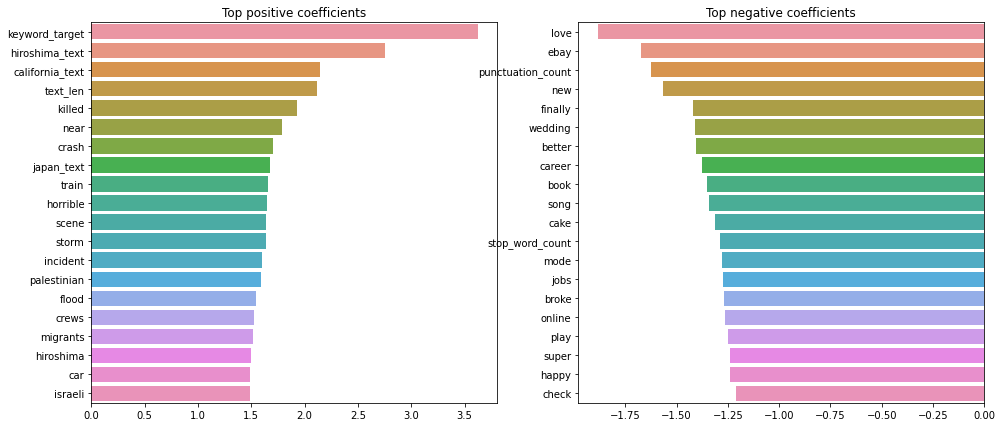

In [81]:
"""
Feature Selection - Identifying the Top Features
"""

plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

## Findings:

'keyword_target' is the top positive coefficient, meaning the keyword column made a good feature
hiroshima both as text and hashtag made the top 20 positive coefficients
Punctuation count and stop word count are among top 20 negative coefficients
None of the bigrams made the top features

In [87]:
"""
step parameter in RFECV corresponds to the (integer) number of features to remove at each iteration.
"""
steps = 10
rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')
pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rfecv',
                 RFECV(cv=ShuffleSplit(n_splits=5, random_state=123, test_size=0.2, train_size=None),
                       estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=777,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                        

In [101]:
"""
RFECV exposes support_ which is another attribute to find out the features which contribute the most to predicting. 
In order to find out which features are selected we can use the following code.
"""

selected_features = X_train.columns[rfecv.support_ == True]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

X_train2.shape

(7613, 1132)

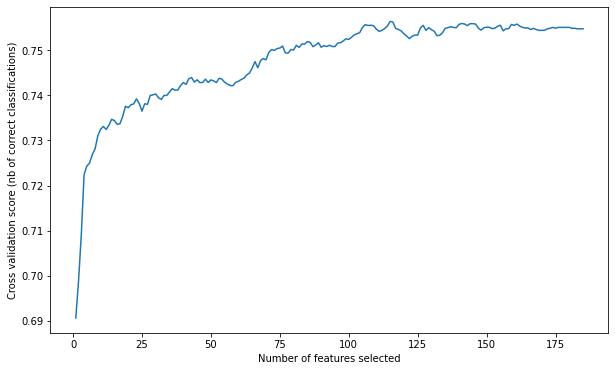

In [89]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [104]:
"""
Grid Search CV - Hyperparamater Tuning
"""

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X_train2, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 1.0, 'penalty': 'l2'}
F-1 score: 0.773


In [105]:

y_test2 = pipeline_grid.predict(X_test2)
submit2 = submission.copy()
submit2.target = y_test2
submit2.to_csv('submit_lr2.csv',index=False)